In [3]:
import gymnasium as gym
import numpy as np
import os, sys
import time
import sys
import traffic_control_game
import pygame
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from traffic_control_game.envs.logic import Setup
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("pastel"))

In [4]:
class QAgent:
  ''' Class for the Q learning agent '''

  def _init_(self):
    # values are initialized with info dictionary
    self.step_size = None
    self.discount = None
    self.epsilon = None
    self.epsilon_decay = None
    self.epsilon_min = None
    self.num_actions = None
    self.Q = None

  def info_init(self, info):
    self.step_size = info.get("step_size", 0.02)
    self.discount = info.get("discount", 1.0)
    self.epsilon = info.get("eps_start", 1.0)
    self.epsilon_decay = info.get("eps_decay", .99999)
    self.epsilon_min = info.get("eps_min", 0.05)
    self.num_actions = info.get("num_actions", 2)

    self.Q = defaultdict(lambda: np.zeros(self.num_actions)) if not info.get("Q", False) else info.get("Q", False)
  
  def get_policy(self):
    ''' Returns optimal policy '''
    return {k: self.argmax(v) for k, v in self.Q.items()}

  def choose_action(self, state):
    ''' Epsilon greedy strategy '''

    if state not in self.Q:
      chosen = np.random.randint(self.num_actions)
    else:
      policy = np.array([self.epsilon/self.num_actions]*self.num_actions)
      policy[self.argmax(self.Q[state])] += 1-self.epsilon
      chosen = np.random.choice(np.arange(self.num_actions), p=policy) 
    return chosen
  
  def argmax(self, values):
    ''' Proper argmax method to break ties evenly '''
    if values[0]==values[1]:
      return np.random.choice(self.num_actions)
    else:
      return np.argmax(values)

  def decay(self):
    ''' Epsilon decay. Basic decay strategy at each episode '''
    self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

  def play(self, env, fin_score = 30000, print_=False, print_info=False):
    ''' Play one game. Does not update estimated state-action values and discards experience '''
    policy = self.get_policy()
    state, info = env.reset()
    if print_info:
      print("The game has started...")
    while True:
        action = policy[state] if state in policy else env.action_space.sample()
        next_state, reward, done, _, info = env.step(action)

        if print_:
          # Render the game
          os.system("clear")
          sys.stdout.write(env.render())
          time.sleep(0.2) # FPS
        
        if (done) or (info["score"]>fin_score-1): # If player is dead break
          to_vis = info["score"]
          if print_info:
            print(f"The game is done! Final score: {to_vis: ,}\n")
          break
        else:
          state = next_state  
    env.close()
    return to_vis


  def update(self, state, action, reward, next_state):
    ''' Method updating estimated state-action value according to Q-learning algorithm
        It is also used to update the one-to-last state if next_state is the boolean False
        (so that terminal state is not updated, and its value is not considered for the other
        updates) '''

    old_Q = self.Q[state][action]
    target = np.amax(self.Q[next_state]) if next_state else 0
    self.Q[state][action] = old_Q + self.step_size*(reward + self.discount*target - old_Q)


def rl_loop(agent, env, info, change_reward=False, drop_epsilon=False, print_=True, print_info=False):
    ''' Main training loop of the Q-learning agent.
        It returns the agent after learning, together with a list of all episode (final) scores
        and a running list storing the best score seen up to that episode '''
    
    num_episodes = info.get("num_episodes", 50000)
    agent.info_init(info)  # agent info initialization

    total_scores, total_max_scores, epsilon_store = [], [], []
    best_score = 0
  
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # if drop_epsilon is an integer, when the episode number is equal to that integer a greedy game is played, and the result returned
        if (drop_epsilon!=False) and (i_episode==int(drop_epsilon)):
          if print_info:
            print(f"Epsilon before evaluation: {agent.epsilon: .4f}, Number of visited states: {len(list(agent.Q.keys()))}, Last max score with epsilon: {total_max_scores[-1]}")
          fin_score = agent.play(env, fin_score=30000, print_=False, print_info=print_info)
          return fin_score
        
        # epsilon geometrical decay
        agent.decay()
        epsilon_store.append(agent.epsilon)
          
        state, info = env.reset()  # env reset
        runn_score = 0

        while True:
            action = agent.choose_action(state)  # chose action

            # take a step in the environement 
            next_state, reward, done,_, info = env.step(action)

            # eventually not used, but an alternative reward system was formalized
            if (change_reward) and (info["score"]>runn_score):
              runn_score = info["score"]
              reward += 100

            # terminate also if score is above a maximum cap (eventually 30k)
            if (done) or (info["score"]>30000):
              if change_reward:  # not used (harsh punishment for terminal state)
                reward = -1000
              agent.update(state, action, reward, False) # update one-to-last state

              # update
              best_score = max(best_score, info["score"])
              total_max_scores.append(best_score)
              total_scores.append(info["score"])
              break

            agent.update(state, action, reward, next_state)
            state=next_state
            continue
        if print_:
          if i_episode % 1000 == 0:
              print("\rEpisode {}/{}, Avg Scores: {}, Max Score: {}.".format(i_episode, num_episodes, np.mean(total_scores).astype(int), total_max_scores[-1]))

    return agent, total_scores, total_max_scores

In [40]:
class QLearningAgent:
    def __init__(self, params, n_episodes, env_info):
        self.params = params
        self.n_episodes = n_episodes
        for key in params:
            setattr(self, key, params[key])

        self.n_actions = 6
        self.action_space = np.array(range(self.n_actions))
        self.init_epsilon = params["epsilon"]


        if self.epsilon_decay:
            self.epsilon_decay_factor = (0.001/self.init_epsilon)**(1/n_episodes)
            self.epsilon_decay_increment = self.init_epsilon/n_episodes

        self.env_info = env_info
        self.n_states = env_info["n_states"]
        
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))
        self.N = defaultdict(lambda: np.zeros(self.n_actions))


        self.history = {
            "scores": np.zeros(n_episodes),
            "reward": np.zeros(n_episodes),
            "epsilon" : np.zeros(n_episodes),
            "chosen_actions": [0]*self.n_actions
        }

    def random_action(self):
        rand_action = np.random.choice(self.action_space)
        return rand_action

    def get_state_tuple(self, obs):
        return (obs["north"], obs["east"], obs["south"],obs["west"]) if self.n_states == 4 else (obs["NS"], obs["WE"])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.RandomState().choice(ties)

    
    def update_history(self, episode, score, epsilon, reward_episode):
        self.history["scores"][episode] = score
        self.history["epsilon"][episode] = epsilon
        self.history["reward"][episode] = reward_episode

    def get_action(self, obs):
        state = self.get_state_tuple(obs)

        if random.random() < self.epsilon:
            return self.random_action()

        return self.argmax(self.Q[state])
    
    def update(self, obs, next_obs, action, reward, done):
        state, next_state  = self.get_state_tuple(obs), self.get_state_tuple(next_obs)

        self.N[state] += 1
        self.Q[state][action] += self.step_size * (reward + self.gamma*np.amax(self.Q[next_state]) - self.Q[state][action])


    def update_epsilon(self):
        if self.epsilon_decay == "linear":
            self.epsilon -= self.epsilon_decay_increment
        elif self.epsilon_decay == "exponential":
            self.epsilon *= self.epsilon_decay_factor

    def states_visited(self):
        visited = [1 if n_visits != 0 else 0 for state, n_visits in self.N.items()]
        return sum(visited)
    

    def get_chosen_actions_ratio(self):
        chosen_actions = self.history["chosen_actions"]
        n_chosen_actions = sum(chosen_actions)
        return [round(action/n_chosen_actions, 4) for action in chosen_actions]
    
    def train(self, n_episodes):
        env = gym.make("traffic_control-v0", env_info = self.env_info, render_mode=None) 
        best_score = 0
        for episode in range(n_episodes):
            obs, info = env.reset()
            reward_episode = 0
            while True:
                # Select next action
                action = self.get_action(obs)   # for an agent, action = agent.policy(observation)
                # Appy action and return new observation of the environment
                next_obs, reward, done, _, info = env.step(action)

                self.update(obs, next_obs, action, reward, done)
                self.history["chosen_actions"][action] += 1
                reward_episode += reward
                obs = next_obs

                env.render()

                if done:
                    break
                
            self.update_epsilon()
            

            score = info["score"]
            self.update_history(episode, score, self.epsilon, reward_episode=reward_episode)
            best_score = score if score > best_score else best_score
            if (episode + 1) % 2 == 0:
                print(f"Episode {episode + 1}/{n_episodes} *** Best score: {best_score}\
 *** Chosen actions: {self.get_chosen_actions_ratio()} ")
                
        env.close()

In [41]:
def plot_results(agent):
    scores = agent.history["scores"]
    epsilons = agent.history["epsilon"]
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    fig.suptitle(f"QLearning agent")
    ax[0].plot(scores, "b")
    ax[0].set_xlabel("Episodes")
    ax[0].set_title(f"Score (best: {max(scores): .0f})")
    ax[1].plot(epsilons, "b")
    ax[1].set_xlabel("Episodes")
    ax[1].set_title(f"Epsilon (final value: {epsilons[-1]: .1e})")
    fig.tight_layout()

In [44]:
N_EPISODES = 100
params = {
    "epsilon": 0.1,
    "epsilon_decay": "linear",
    "step_size": 0.1,
    "gamma": 1
}
env_steps = 30
max_waiting_time = 1500
ps_ns = np.random.uniform(low=0.09, high=0.1, size=1)
ps_ew = np.random.uniform(low=0.04, high=0.05, size=1)
ps = np.tile(np.concatenate((ps_ns, ps_ew)), 2)

env_info = {"ps": ps, "max_wait_time": max_waiting_time, "env_steps": env_steps, "n_states": 2}        



agent = QLearningAgent(params, N_EPISODES, env_info = env_info)

Here epsilon greedy does not lead to more exploration!! (only more actions, but not more states)

In [45]:
agent.train(N_EPISODES)

Episode 2/100 *** Best score: 44 *** Chosen actions: [0.1042, 0.1667, 0.125, 0.3542, 0.1458, 0.1042] 
Episode 4/100 *** Best score: 44 *** Chosen actions: [0.1319, 0.1209, 0.1868, 0.3516, 0.1099, 0.0989] 
Episode 6/100 *** Best score: 44 *** Chosen actions: [0.1377, 0.1449, 0.1812, 0.2826, 0.1377, 0.1159] 
Episode 8/100 *** Best score: 44 *** Chosen actions: [0.1484, 0.1484, 0.1703, 0.2527, 0.1538, 0.1264] 
Episode 10/100 *** Best score: 44 *** Chosen actions: [0.1491, 0.1447, 0.1623, 0.2456, 0.1667, 0.1316] 
Episode 12/100 *** Best score: 44 *** Chosen actions: [0.161, 0.1348, 0.1536, 0.221, 0.176, 0.1536] 
Episode 14/100 *** Best score: 136 *** Chosen actions: [0.1815, 0.1577, 0.1488, 0.1905, 0.1815, 0.1399] 
Episode 16/100 *** Best score: 136 *** Chosen actions: [0.1722, 0.1671, 0.1542, 0.1774, 0.1851, 0.144] 
Episode 18/100 *** Best score: 136 *** Chosen actions: [0.1652, 0.1853, 0.1629, 0.1652, 0.1853, 0.1362] 
Episode 20/100 *** Best score: 136 *** Chosen actions: [0.171, 0.1791,

In [46]:
agent.Q

defaultdict(<function __main__.QLearningAgent.__init__.<locals>.<lambda>()>,
            {(0,
              0): array([-728.63902147, -482.28773786, -473.50786848, -793.69697254,
                    -466.71299191, -424.232633  ]),
             (0,
              1): array([-241.90259758, -240.71876834, -242.04052588, -221.78047817,
                    -210.05296116, -231.17647398]),
             (1,
              0): array([-420.7511173 , -422.05069313, -421.06564352, -524.664467  ,
                    -430.65697729, -631.82152417]),
             (0,
              3): array([   0.    ,   -6.9   ,    0.    , -500.1489,  -15.6   ,    0.    ]),
             (2,
              0): array([-224.7684611 , -243.82666119, -243.71508541, -481.38408739,
                    -240.54026927, -231.22168643]),
             (7,
              0): array([-21.37980978, -13.2       , -10.5       , -20.93097238,
                    -22.4       , -29.17      ]),
             (8,
              0): array([-24.8  

In [14]:
env = gym.make("traffic_control-v0", num_actions = 4) 
best_score = 0
for episode in range(N_EPISODES):
    obs, info = env.reset()
    while True:
        # Select next action
        action = agent.get_action(obs)   # for an agent, action = agent.policy(observation)
        
        # Appy action and return new observation of the environment
        next_obs, reward, done, _, info = env.step(action)

        agent.update(obs, next_obs, action, reward, done)
        obs = next_obs

        env.render()

        if done:
            break
        
    agent.update_epsilon()
    

    score = info["score"]
    agent.update_history(episode, score, agent.epsilon)
    best_score = score if score > best_score else best_score
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{N_EPISODES} *** Best score:", best_score)
        

env.close()

Episode 50/10000 *** Best score: 5
Episode 100/10000 *** Best score: 14
Episode 150/10000 *** Best score: 19
Episode 200/10000 *** Best score: 19
Episode 250/10000 *** Best score: 22
Episode 300/10000 *** Best score: 23
Episode 350/10000 *** Best score: 23
Episode 400/10000 *** Best score: 25
Episode 450/10000 *** Best score: 25
Episode 500/10000 *** Best score: 25
Episode 550/10000 *** Best score: 25
Episode 600/10000 *** Best score: 25
Episode 650/10000 *** Best score: 25
Episode 700/10000 *** Best score: 25
Episode 750/10000 *** Best score: 25
Episode 800/10000 *** Best score: 26
Episode 850/10000 *** Best score: 26
Episode 900/10000 *** Best score: 30
Episode 950/10000 *** Best score: 30
Episode 1000/10000 *** Best score: 30
Episode 1050/10000 *** Best score: 30
Episode 1100/10000 *** Best score: 31
Episode 1150/10000 *** Best score: 31
Episode 1200/10000 *** Best score: 32
Episode 1250/10000 *** Best score: 32
Episode 1300/10000 *** Best score: 32
Episode 1350/10000 *** Best score

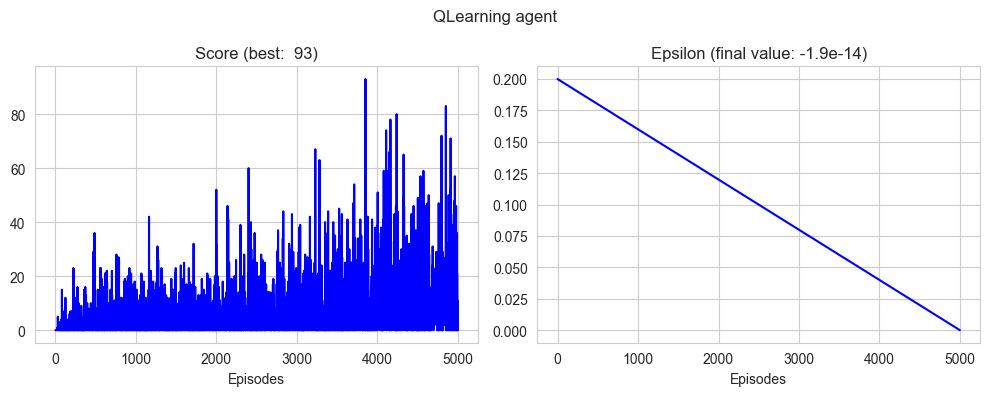

In [7]:
plot_results(agent)

In [50]:
agent.history["chosen_actions"]

[5846, 6335, 13263, 2135]

In [20]:
import json
q = agent.Q.copy()
key_value = list(q.items())
for key, val in key_value:
    q[str(key)] = val
    q.pop(key)
n = agent.N.copy()
key_value = list(n.items())
for key, val in key_value:
    n[str(key)] = val
    n.pop(key)
res = {
    "scores" : list(agent.history["scores"]),
    "epsilon" : list(agent.history["epsilon"]),
    "Q" : q,
    "N": n
}
filename = "run1"

with open("./results/QLearning/" + filename + ".json", "w") as f:
    json.dump(res, f)